# **1. Load Library**

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose # Decompose plot
from statsmodels.tsa.stattools import adfuller # Augmented Dickey-Fuller Test (Differencing)
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Plot ACF & PACF (AR, MA)
from statsmodels.tsa.arima.model import ARIMA # ARIMA
from scipy.stats import t # t-distribution
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
!pip install arch
from arch import arch_model # GARCH Modelling

# **2. Load Dataset**

In [3]:
oil = pd.read_csv("/content/drive/MyDrive/Sem_3/Time Series/TS_GroupAssignment_2/Copy-Brent Oil Futures Historical Data.csv")
# oil = pd.read_csv("/content/Copy-Brent Oil Futures Historical Data.csv")

In [4]:
oil.head(5)

,Date,Price,Open,High,Low,Vol.,Change %
0,12-12-2025,61.12,61.60,61.86,60.81,246.06K,-0.26%
1,11-12-2025,61.28,62.42,62.63,60.77,328.70K,-1.49%
2,10-12-2025,62.21,62.11,62.73,61.35,298.74K,0.44%
3,09-12-2025,61.94,62.54,62.78,61.83,240.38K,-0.88%
4,08-12-2025,62.49,63.75,63.96,62.34,276.73K,-1.98%


In [5]:
oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1020 entries, 0 to 1019
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      1020 non-null   object 
 1   Price     1020 non-null   float64
 2   Open      1020 non-null   float64
 3   High      1020 non-null   float64
 4   Low       1020 non-null   float64
 5   Vol.      1020 non-null   object 
 6   Change %  1020 non-null   object 
dtypes: float64(4), object(3)
memory usage: 55.9+ KB


# **3. Pre-processing**

In [6]:
# Change data type
oil['Date'] = pd.to_datetime(oil['Date'], format = '%d-%m-%Y')

# Recheck data type again
oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1020 entries, 0 to 1019
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      1020 non-null   datetime64[ns]
 1   Price     1020 non-null   float64       
 2   Open      1020 non-null   float64       
 3   High      1020 non-null   float64       
 4   Low       1020 non-null   float64       
 5   Vol.      1020 non-null   object        
 6   Change %  1020 non-null   object        
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 55.9+ KB


In [7]:
# Create new data set with required variables
oil_new = oil[['Date','Price']]

# Sort 'Date' variable
oil_new = oil_new.sort_values('Date')

# Set index
oil_new = oil_new.set_index('Date')

# Set frequency as "B" indicate business day
oil_new = oil_new.asfreq('B')

# Since the oil trading days are not continuous (No trade during weekends/holidays)
# So this gap is consider missing value in time series
# Thus this missing value need to be filled with certain value
# Fill weekends/holidays/non-trade days using .ffill() function
# So the missing value will be imputed with the last known value
oil_new['Price'] = oil_new['Price'].ffill()

print(oil_new.head(5))

            Price
Date             
2022-01-03  78.98
2022-01-04  80.00
2022-01-05  80.80
2022-01-06  81.99
2022-01-07  81.75


In [8]:
print(oil_new.tail(5))

            Price
Date             
2025-12-08  62.49
2025-12-09  61.94
2025-12-10  62.21
2025-12-11  61.28
2025-12-12  61.12


In [9]:
# Check again whether there is still missing value or not
# Returns the sum of null values for each column
print(oil_new.isnull().sum())

Price    0
dtype: int64


# **4. **Splitting** Data Set**

In [10]:
train_size = int(len(oil_new) * 0.8)

# Split into train and test
train_data = oil_new.iloc[:train_size]
test_data = oil_new.iloc[train_size:]

# **5. Visualization**

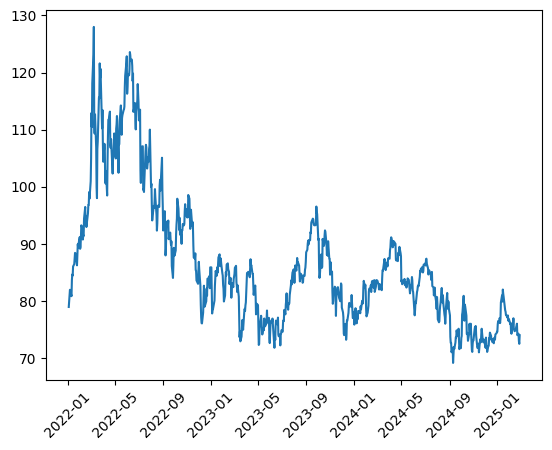

In [11]:
#Visualize
plt.plot(train_data['Price'])
plt.xticks(rotation=45)
plt.show()

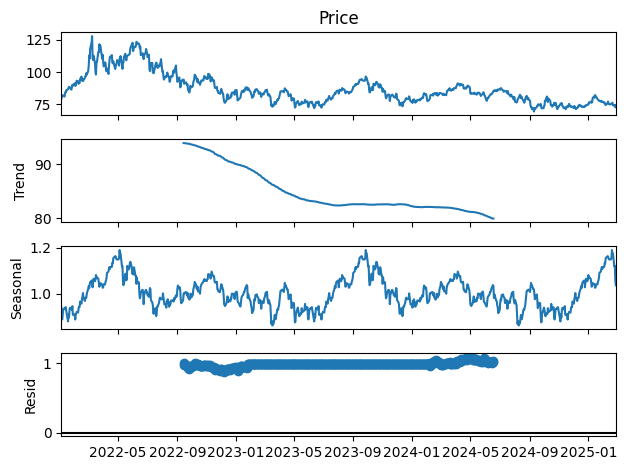

In [12]:
# Decompose Time Series Data

oil_decompose = seasonal_decompose(train_data['Price'],
                                   model = 'multiplicative',
                                   period = 365)

plt.show(oil_decompose.plot())

# **6. Stationary & Volatility Check**

## **6(i) Stationarity**

### ***6(i)(a) Visualize the ACF Plot to check stationarity***

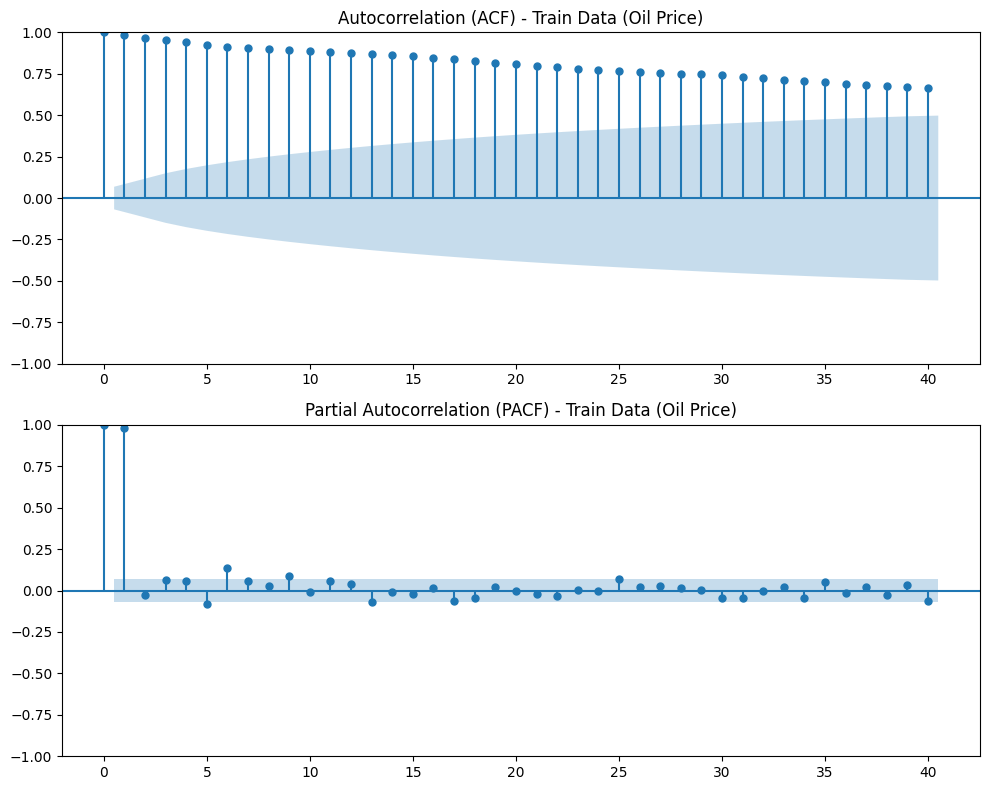

In [13]:
# Define the figure layout
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot ACF: Identify whether time series is stationary or not and the MA (q) term
plot_acf(train_data['Price'], ax=ax1, lags=40, title="Autocorrelation (ACF) - Train Data (Oil Price)")

# Plot PACF: helps identify the AR (p) term
plot_pacf(train_data['Price'], ax=ax2, lags=40, title="Partial Autocorrelation (PACF) - Train Data (Oil Price)")

plt.tight_layout()
plt.show()

# Based on the ACF plot, values decrease very slowly, lingering long past the confidence interval, indicating a strong trend
# Thus, data is non-stationary

### ***6(i)(b) Using ADF Test to check stationarity***

In [14]:
# Check wether dataset is stationary or not
# If p-value is less than 0.05, it means times series is Stationary
# Based on the following hypothesis
# H0:Time Series is not stationary
# H10:Time Series is stationary

adf_result = adfuller(train_data['Price']) # Perform ADF Test

print(f'ADF p-value: {adf_result[1]}')
# ADF p-value: 0.5872762166406739
# Since the p-value is > 0.05, thus fail to reject H0:Time Series is not stationary
# So the oil price is non-stationary

ADF p-value: 0.5121417978904079


### ***6(i)(c) Differencing to make time series data stationary***

In [15]:
# First-order differencing:
diff_price = train_data['Price'].diff().dropna()

### ***6(i)(d) Visualize the ACF Plot to check stationarity***

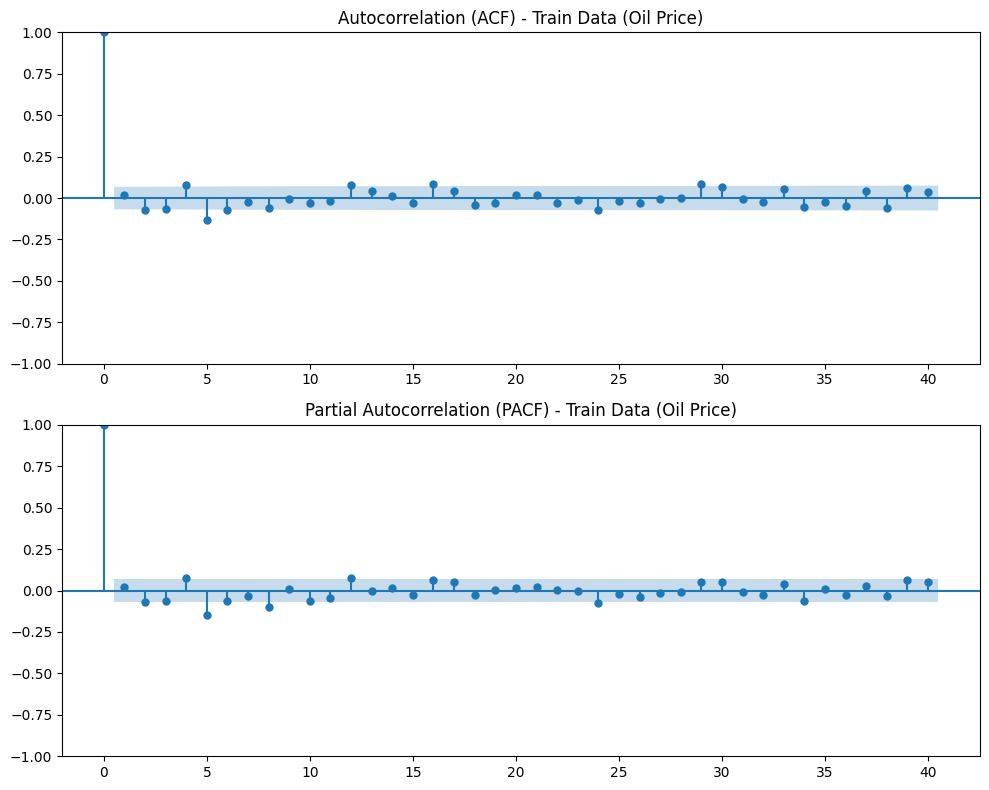

In [16]:
# Define the figure layout
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot ACF: Identify whether time series is stationary or not and the MA (q) term
plot_acf(diff_price, ax=ax1, lags=40, title="Autocorrelation (ACF) - Train Data (Oil Price)")

# Plot PACF: helps identify the AR (p) term
plot_pacf(diff_price, ax=ax2, lags=40, title="Partial Autocorrelation (PACF) - Train Data (Oil Price)")

plt.tight_layout()
plt.show()

# After performed First-Order Differencing, the time series data seems stationary
# ACF bars drop quickly to within the confidence interval) after at Lag 1
# Based on ACF plot, the MA model is MA(1) due to sharp cutoff after lag 1
# Based on PACF plot, the AR model is AR(1) due to sharp cutoff after lag 1

### ***6(i)(e) Using ADF Test to check stationarity***

In [17]:
# Check wether dataset is stationary or not
# If p-value is less than 0.05, it means times series is Stationary
# Based on the following hypothesis
# H0:Time Series is not stationary
# H10:Time Series is stationary

adf_result = adfuller(diff_price) # Perform ADF Test

print(f'ADF p-value: {adf_result[1]}')
# ADF p-value: 2.104078891776444e-18
# Since the p-value is less than 0.05, thus reject H0:Time Series is not stationary
# So the time series data is stationary

ADF p-value: 1.2775062631908764e-16


## **6(ii) Volatility Clustering - for GARCH**

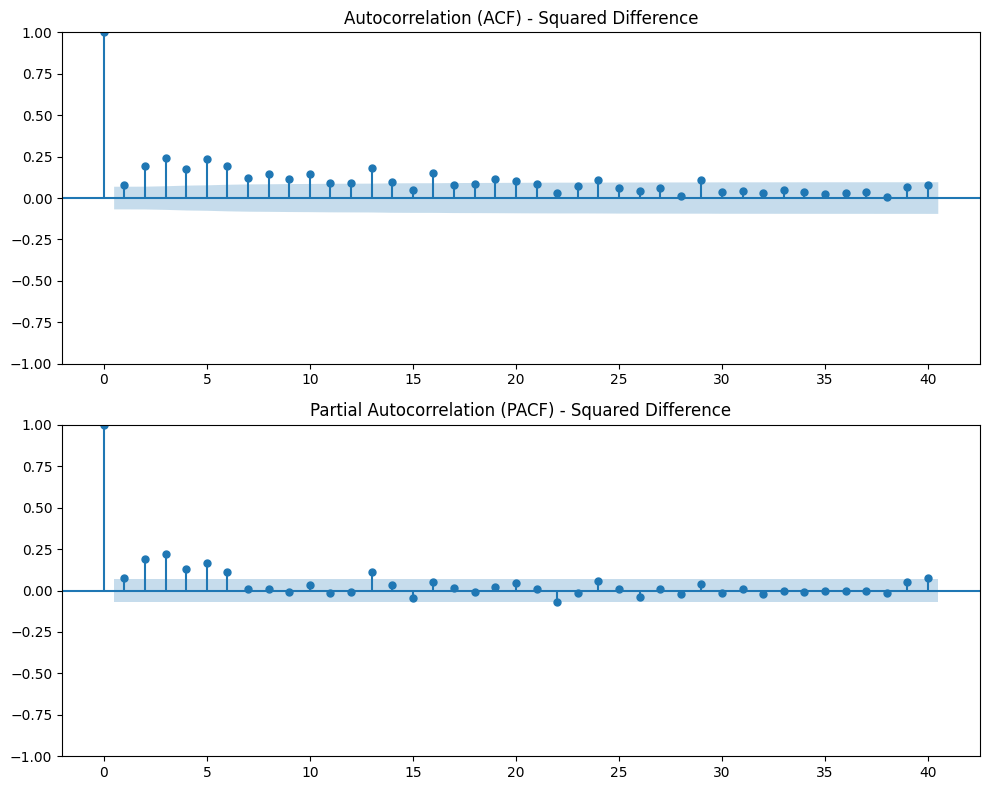

In [18]:
# Volatility clustering means large changes tend to be followed by large changes, and small changes by small changes

# Create Squared Differences based on output of previous differencing

sq_diff = diff_price**2

# Define the figure layout
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot ACF : SQUARED differences
plot_acf(sq_diff, ax=ax1, lags=40, title="Autocorrelation (ACF) - Squared Difference")

# Plot PACF : SQUARED differences
plot_pacf(sq_diff, ax=ax2, lags=40, title="Partial Autocorrelation (PACF) - Squared Difference")

plt.tight_layout()
plt.show()

# Based on the ACF and PACF plot of Squared Difference,
# There is a significant, positive spike at Lag 1.
# The following lags also significant because there are outside the confidence interval.
# Thus, A GARCH (Generalized Autoregressive Conditional Heteroskedasticity) model is required.
# The significant autocorrelation in the Squared Differences indicate volatility clustering exist in the oil price data set.
# It shows that the size of price change today is correleted with the size of the price change yesterday.
# This volatility shows data is heteroskedastic (not constant) which is suitable to be used with the GARCH model.

# **7. Modelling the Data Set**

### ***Option 1 : ARIMA***

In [19]:
# Fit ARIMA Modelling
# (p,d,q) = (1,1,1)
arima_model = ARIMA(train_data['Price'], order=(1, 1, 1)).fit()

# ARIMA Model summary of results
print(arima_model.summary())

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  824
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1763.473
Date:                Mon, 12 Jan 2026   AIC                           3532.946
Time:                        10:22:41   BIC                           3547.085
Sample:                    01-03-2022   HQIC                          3538.370
                         - 02-27-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8399      0.057     14.704      0.000       0.728       0.952
ma.L1         -0.8956      0.047    -19.030      0.000      -0.988      -0.803
sigma2         4.2526      0.111     38.158      0.0

**Based on the ARIMA model above:**

*   There is a strong positive relationship between current value and previous value with a coeeficient of 0.399. The p-value of ar.L1 is 0.000 indicates statistically significants.


*   The p-value for ma.L1 is highly significant with 0.000 which indicates the previous forecast errors are helpfun in predciting current value.

* The probability of LjungBox at 0.08 suggests residuals are independent.

* The probability of Heteroskedasticity at 0.00 indicates that variance of errors change over time.

* The probability of Jarque-Bera at 0.00 indicates residuals are not normally distributed.



### ***Option 2 : ARIMA - GARCH***

In [20]:
# Fit ARIMA Modelling
# (p,d,q) = (1,1,1)
arima_model = ARIMA(train_data['Price'], order=(1, 1, 1)).fit()
arima_resid = arima_model.resid

# Fit GARCH Modelling
# For GARCH, p = 1 and q = 1 which frequently sufficient for financial data
# mean='Zero' because this has been cater by ARIMA model above
garch_model = arch_model(arima_resid,
                         vol='Garch', p=1, q=1,
                         mean = "Zero",
                         dist='t').fit(disp='off')

# GARCH Model summary of results
print(garch_model.summary())

                          Zero Mean - GARCH Model Results                           
Dep. Variable:                         None   R-squared:                       0.000
Mean Model:                       Zero Mean   Adj. R-squared:                  0.001
Vol Model:                            GARCH   Log-Likelihood:               -1653.94
Distribution:      Standardized Student's t   AIC:                           3315.88
Method:                  Maximum Likelihood   BIC:                           3334.74
                                              No. Observations:                  824
Date:                      Mon, Jan 12 2026   Df Residuals:                      824
Time:                              10:22:42   Df Model:                            0
                              Volatility Model                             
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega  

**Based on the ARIMA-GARCH model above:**

*   **Volatility Model**
    *   The p-value for alpha[1] is  1.229e-03 < 0.05. This is significant which indicates immediate market shocks impact volatility.
    *   The p-value for beta[1] is  8.416e-16  < 0.05. This is significant which indicates Volatility is very long-lasting (persistent).

*   **Distribution**
    *   The p-value for nu is  3.849e-07 < 0.05. This is significant which indicates there are more extreme price jumps than a normal bell curve would predict.




**SUMMARY**

**Between ARIMA model and ARIMA-Garch model, ARIMA-GARCH model is a better model since its AIC value at  3315.88 which is lower than 3532.946 (ARIMA Model).**

# **8. Forecast - Using ARIMA Model**

In [28]:
# Forecast ARIMA
# This will give the Forecasted Price Level
horizon = len(test_data)
fc_arima_only = arima_model.get_forecast(steps = horizon)
fc_price_pl_arima_only = fc_arima_only.predicted_mean
stderr = fc_arima_only.se_mean

# Create dataframe to store information on AR-GARCH
arima_df = pd.DataFrame ({
    'day' : np.arange(1, horizon + 1),
    'actual_price': test_data['Price'].values,
    'forecast_price' : fc_price_pl_arima_only.values,
    }, index=test_data.index)

# Add Confidence Interval For Price Level
arima_df['lwr_pl'] = arima_df['forecast_price'] - (1.96* stderr.values)
arima_df['upr_pl'] = arima_df['forecast_price'] + (1.96* stderr.values)


In [29]:
print("head".title())
arima_df.head(5)

Head


,day,actual_price,forecast_price,lwr_pl,upr_pl
Date,,,,,
2025-02-28,1,73.18,74.092986,70.051107,78.134864
2025-03-03,2,71.62,74.137490,68.578314,79.696667
2025-03-04,3,71.04,74.174872,67.536764,80.812979
2025-03-05,4,69.30,74.206270,66.716448,81.696092
2025-03-06,5,69.46,74.232642,66.033696,82.431588


In [30]:
print("tail".title())
arima_df.tail(5)

Tail


,day,actual_price,forecast_price,lwr_pl,upr_pl
Date,,,,,
2025-12-08,202,62.49,74.371034,36.213173,112.528895
2025-12-09,203,61.94,74.371034,36.122271,112.619797
2025-12-10,204,62.21,74.371034,36.031585,112.710483
2025-12-11,205,61.28,74.371034,35.941113,112.800955
2025-12-12,206,61.12,74.371034,35.850853,112.891215


### ***MAE & RMSE***

In [31]:
actuals = arima_df['actual_price'].values
predictions = arima_df['forecast_price'].values

# 2. Calculate MAE
mae = mean_absolute_error(actuals, predictions)

# 3. Calculate RMSE
mse = mean_squared_error(actuals, predictions)
rmse = np.sqrt(mse)

# 4. Print results
print(f"--- Model Performance Metrics ---")
print(f"MAE  (Mean Absolute Error):  {mae:.4f}")
print(f"RMSE (Root Mean Squared Error): {rmse:.4f}")

--- Model Performance Metrics ---
MAE  (Mean Absolute Error):  7.6861
RMSE (Root Mean Squared Error): 8.3625


### ***Residuals Plot***

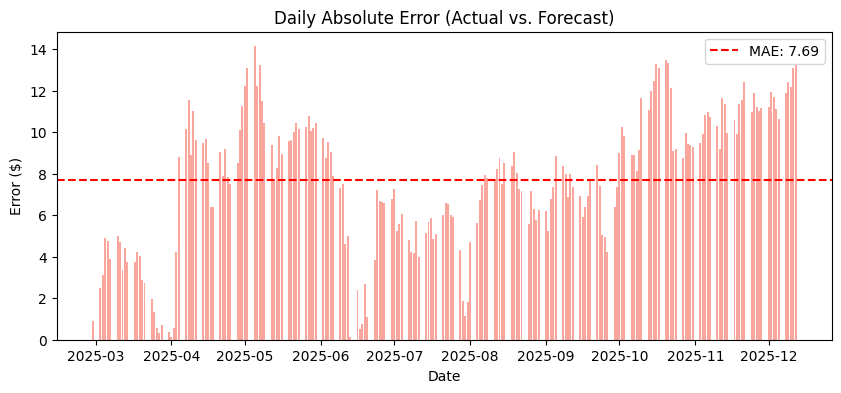

In [32]:
# Plotting the residuals
plt.figure(figsize=(10, 4))
plt.bar(arima_df.index,
        np.abs(arima_df['actual_price'] - arima_df['forecast_price']),
               color='salmon', alpha=0.7)
plt.axhline(y=7.6861, color='red', linestyle='--', label=f'MAE: 7.69')
plt.title('Daily Absolute Error (Actual vs. Forecast)')
plt.xlabel('Date')
plt.ylabel('Error ($)')
plt.legend()
plt.show()

### ***Price Level Plot***

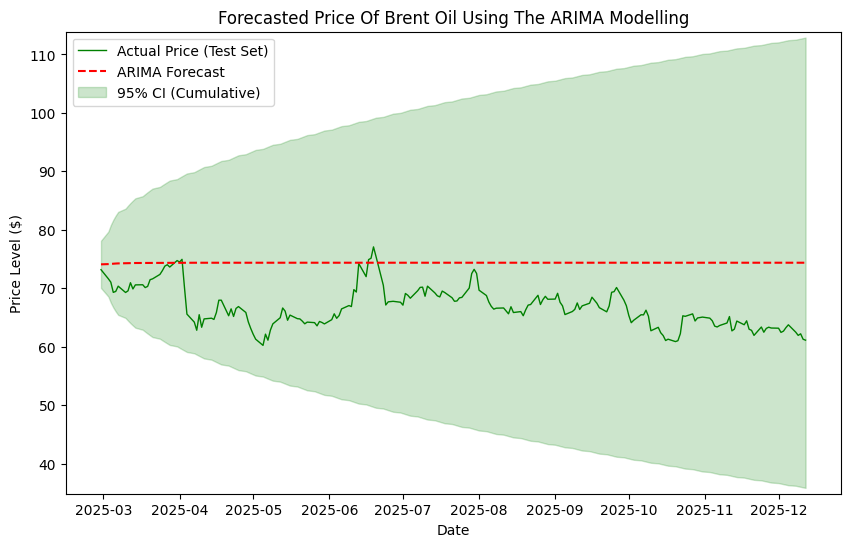

In [33]:
# Define plot size
plt.figure(figsize=(10, 6))

# Plot the Actuals vs Forecast
plt.plot(arima_df.index, arima_df['actual_price'], label='Actual Price (Test Set)', color='green', linewidth=1)
plt.plot(arima_df.index, arima_df['forecast_price'], label='ARIMA Forecast', color='red', linestyle='--')

# Plot Confidence Interval
plt.fill_between(arima_df.index,
                 arima_df['lwr_pl'],
                 arima_df['upr_pl'],
                 alpha=0.2, color='green', label='95% CI (Cumulative)')

# Formatting
plt.title('Forecasted Price Of Brent Oil Using The ARIMA Modelling')
plt.xlabel('Date')
plt.ylabel('Price Level ($)')
plt.ylim(arima_df['lwr_pl'].min() - 1, arima_df['upr_pl'].max() + 1)
plt.legend()

plt.show()

### **9. Forecast - Using ARIMA-GARCH Model**

In [21]:
# Forecast ARIMA
# This will give the Forecasted Price Level
horizon = len(test_data)
fc_arima = arima_model.forecast(steps = horizon)
fc_price_pl_arima = fc_arima

# Forecast Expected Daily Change
last_price =  train_data['Price'].iloc[-1]
price_series = np.insert(fc_price_pl_arima.values, 0, last_price)
fc_mean_arima = np.diff(price_series)

# Forecast GARCH
fc_garch = garch_model.forecast(horizon = horizon, reindex = False)

# Forecast Variance (Expected Volatility)
fc_var_garch = fc_garch.variance.iloc[-1]

# Calculate Standard Deviation Daily Changes which is the basis
# to calculate the “Daily Changes” confidence interval
fc_sd_dc_garch = np.sqrt(fc_var_garch.values)

# Calculate Standard Deviation Price Level which is the basis
# to calculate the “Price Level” confidence interval
# .cumsum() is use for price level because the uncertainty will accumulate for day to day
fc_sd_pl_garch = np.sqrt(fc_var_garch.cumsum().values)

# Create robust “day” variable
days = np.arange(1, horizon + 1)

# Calculate t-multiplier for confidence interval
# When using dist = ‘t’ in garch model, the fixed multiplier of 1.96 is not suitable because it will likely underestimate the risk
# since 1.96 assume the data is normally distributed

# Extract Degree of Freedom (nu)
dof = garch_model.params['nu']

# Calculate multiplier for 95% confidence
# use 0.975 for 2-tailed 95% interval
t_mult = t.ppf(0.975, df = dof)

# Create dataframe to store information on AR-GARCH
arima_garch_df = pd.DataFrame ({
    'day' : days,
    'actual_price': test_data['Price'].values,
    'daily_change' : fc_mean_arima,
    'daily_sd' : fc_sd_dc_garch,
    'forecast_price' : fc_price_pl_arima.values,
    'price_sd' : fc_sd_pl_garch
    }, index=test_data.index)

# Add Confidence Interval For Daily Changes
arima_garch_df['lwr_dc'] = arima_garch_df['daily_change'] - (t_mult* arima_garch_df['daily_sd'])
arima_garch_df['upr_dc'] = arima_garch_df['daily_change'] + (t_mult* arima_garch_df['daily_sd'])

# Add Confidence Interval For Price Level
arima_garch_df['lwr_pl'] = arima_garch_df['forecast_price'] - (t_mult* arima_garch_df['price_sd'])
arima_garch_df['upr_pl'] = arima_garch_df['forecast_price'] + (t_mult* arima_garch_df['price_sd'])


In [22]:
print("head".title())
arima_garch_df.head(5)

Head


,day,actual_price,daily_change,daily_sd,forecast_price,price_sd,lwr_dc,upr_dc,lwr_pl,upr_pl
Date,,,,,,,,,,
2025-02-28,1,73.18,0.052986,1.391490,74.092986,1.391490,-3.335826,3.441797,70.704174,77.481797
2025-03-03,2,71.62,0.044505,1.441228,74.137490,2.003343,-3.465440,3.554450,69.258581,79.016400
2025-03-04,3,71.04,0.037381,1.486105,74.174872,2.494372,-3.581856,3.656619,68.100118,80.249626
2025-03-05,4,69.30,0.031398,1.526760,74.206270,2.924532,-3.686850,3.749646,67.083910,81.328629
2025-03-06,5,69.46,0.026372,1.563715,74.232642,3.316337,-3.781874,3.834618,66.156087,82.309197


In [23]:
print("tail".title())
arima_garch_df.tail(5)

Tail


,day,actual_price,daily_change,daily_sd,forecast_price,price_sd,lwr_dc,upr_dc,lwr_pl,upr_pl
Date,,,,,,,,,,
2025-12-08,202,62.49,0.0,2.005035,74.371034,27.950881,-4.883032,4.883032,6.299899,142.442170
2025-12-09,203,61.94,0.0,2.005035,74.371034,28.022703,-4.883032,4.883032,6.124983,142.617085
2025-12-10,204,62.21,0.0,2.005035,74.371034,28.094342,-4.883032,4.883032,5.950515,142.791554
2025-12-11,205,61.28,0.0,2.005035,74.371034,28.165799,-4.883032,4.883032,5.776490,142.965578
2025-12-12,206,61.12,0.0,2.005035,74.371034,28.237075,-4.883032,4.883032,5.602906,143.139163


### ***MAE & RMSE***

In [24]:
# 1. Ensure both are the same length (30 days)
# actual_prices should be the 30 days of real data the model hasn't seen
actuals = arima_garch_df['actual_price'].values
predictions = arima_garch_df['forecast_price'].values

# 2. Calculate MAE
mae = mean_absolute_error(actuals, predictions)

# 3. Calculate RMSE
mse = mean_squared_error(actuals, predictions)
rmse = np.sqrt(mse)

# 4. Print results
print(f"--- Model Performance Metrics ---")
print(f"MAE  (Mean Absolute Error):  {mae:.4f}")
print(f"RMSE (Root Mean Squared Error): {rmse:.4f}")

--- Model Performance Metrics ---
MAE  (Mean Absolute Error):  7.6861
RMSE (Root Mean Squared Error): 8.3625


### ***Residuals Plot***

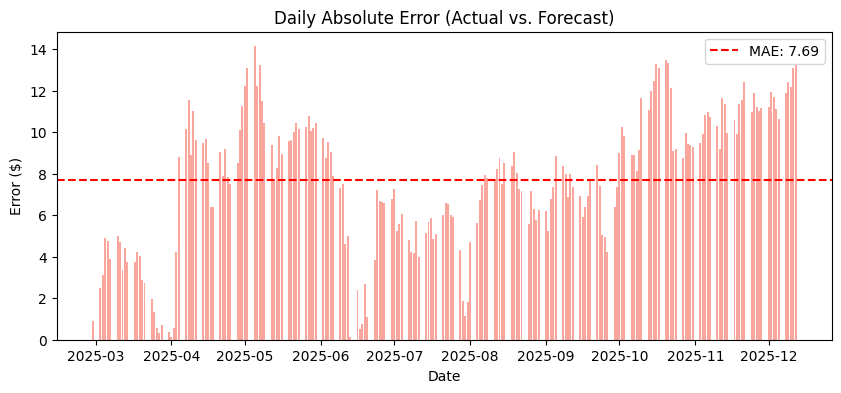

In [25]:
# Plotting the residuals
plt.figure(figsize=(10, 4))
plt.bar(arima_garch_df.index,
        np.abs(arima_garch_df['actual_price'] - arima_garch_df['forecast_price']),
               color='salmon', alpha=0.7)
plt.axhline(y=7.6861, color='red', linestyle='--', label=f'MAE: 7.69')
plt.title('Daily Absolute Error (Actual vs. Forecast)')
plt.xlabel('Date')
plt.ylabel('Error ($)')
plt.legend()
plt.show()

### ***Daily Changes Plot***

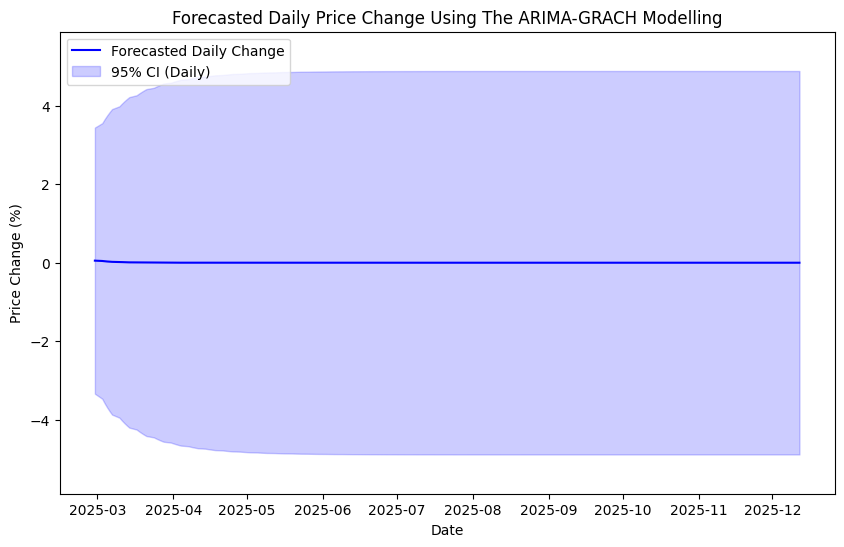

In [26]:
# Define plot size
plt.figure(figsize=(10, 6))

# Plot Forecasted Daily Change
plt.plot(arima_garch_df.index, arima_garch_df['daily_change'],
         label='Forecasted Daily Change', color='blue')

# Plot Confidence Interval
plt.fill_between(arima_garch_df.index,
                 arima_garch_df['lwr_dc'],
                 arima_garch_df['upr_dc'],
                 alpha=0.2, color='blue', label='95% CI (Daily)')

# Formatting
plt.title('Forecasted Daily Price Change Using The ARIMA-GRACH Modelling')
plt.xlabel('Date')
plt.ylabel('Price Change (%)')
plt.ylim(arima_garch_df['lwr_dc'].min() - 1, arima_garch_df['upr_dc'].max() + 1)
plt.legend()

plt.show()


### ***Price Level Plot***

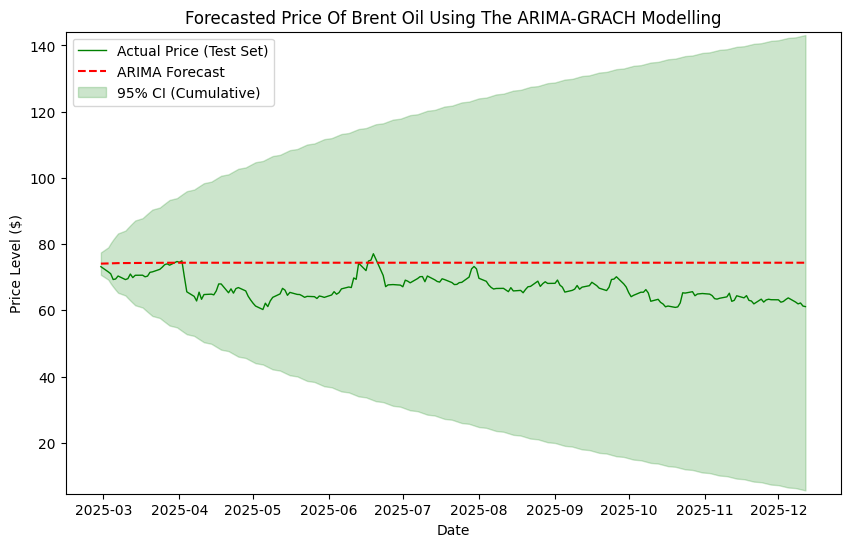

In [27]:
# Define plot size
plt.figure(figsize=(10, 6))

# Plot the Actuals vs Forecast
plt.plot(arima_garch_df.index, arima_garch_df['actual_price'], label='Actual Price (Test Set)', color='green', linewidth=1)
plt.plot(arima_garch_df.index, arima_garch_df['forecast_price'], label='ARIMA Forecast', color='red', linestyle='--')

# Plot Confidence Interval
plt.fill_between(arima_garch_df.index,
                 arima_garch_df['lwr_pl'],
                 arima_garch_df['upr_pl'],
                 alpha=0.2, color='green', label='95% CI (Cumulative)')

# Formatting
plt.title('Forecasted Price Of Brent Oil Using The ARIMA-GRACH Modelling')
plt.xlabel('Date')
plt.ylabel('Price Level ($)')
plt.ylim(arima_garch_df['lwr_pl'].min() - 1, arima_garch_df['upr_pl'].max() + 1)
plt.legend()

plt.show()


# **Conclusion**

1. Analysis of Predictive Performance (MAE and RMSE)

The Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE) for both the standalone ARIMA and the combined ARIMA-GARCH models are identical. This result is attributed to the following factors:

Separation of Mean and Variance: Both models utilize the same ARIMA specification to forecast the "center" or conditional mean of the price series.

Stepwise Estimation Approach: Because Python’s standard libraries (such as statsmodels and arch) do not currently support a single function for simultaneous ARIMA-GARCH estimation, the models were executed sequentially.

Fixed Mean Forecasts: Since the GARCH component was applied to the residuals of the previously fitted ARIMA model, the point forecasts remained unchanged, leading to equivalent error metrics.

2. Model Selection and Comparative Indicators

As MAE and RMSE are insufficient for distinguishing between the two models in this framework, alternative statistical indicators were employed to identify the superior model:

* ***Akaike Information Criterion (AIC)***

ARIMA AIC: 3532.946

ARIMA-GARCH AIC: 3315.88

Interpretation: The ARIMA-GARCH model exhibits a significantly lower AIC, indicating a superior balance between model complexity and goodness-of-fit. This suggests that the ARIMA-GARCH model minimizes information loss and is more robust against overfitting compared to the standalone ARIMA model.

* ***Log-Likelihood***
ARIMA Log-Likelihood: -1763.473

ARIMA-GARCH Log-Likelihood: -1653.94

Interpretation: The ARIMA-GARCH model produced a substantially higher log-likelihood, demonstrating that the observed data is much more likely to have been generated by this specification. This confirms that accounting for time-varying volatility clusters (Heteroskedasticity) provides a much more accurate representation of the underlying data-generating process than a constant-variance ARIMA model.

***Conclusion: Based on the AIC and Log-Likelihood metrics, the ARIMA-GARCH model is the superior model, as it successfully captures the volatility dynamics that the standard ARIMA model fails to address.***